In [23]:
import os
import sys
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

sys.path.append('../')

from mpl_settings_v3 import *

%matplotlib inline

draft_figs_dir = '../../../drafts/results_summary/figs'
figs_dir = '../../../figs/clustering'

In [2]:
def protocolName(mode, init_mu, step, samples, transit, decorr, rampe):
    
    protocol = '{}_{}_muInit{:.6f}_step{:.6f}_samples{:06}_transit{:06d}_decorr{:06d}'.format(mode, rampe, init_mu, step, samples, transit, decorr)
    
    return protocol

get_mu = lambda name: float(name.split('mu')[1].split('_')[0])
get_sample = lambda name: int(name.split('sample')[1].split('.')[0])

In [14]:
net_dir = '../../../networks/real'

network = 'ca-netscience'

mode = 'maxC'
min_mu = 0
max_mu = 15
step = 0.3
samples = 100
decorr = 1
transit = 10
seed = 0

rampes = ['annealing', 'cooling']
files = {}
data = {}
seed_dir = 'seed{:05}'.format(seed)

for rampe in rampes:
    
    if rampe == 'annealing':
        init_mu = min_mu
    else:
        init_mu = max_mu
    protocol = protocolName(mode, init_mu, step, samples, transit, decorr, rampe)
    input_dir = os.path.join(net_dir, network, protocol, seed_dir)
    if not os.path.isdir(input_dir):
        print(input_dir)
    files[rampe] = sorted(os.listdir(input_dir))  

    data[rampe] = []
    
    for f in files[rampe]:
        mu = get_mu(f)
        sample = get_sample(f)

        full_path = os.path.join(input_dir, f)
        g = ig.Graph().Read_Edgelist(full_path, directed=False)
        C = g.transitivity_undirected(mode='zero')
        Cws = g.transitivity_avglocal_undirected(mode='zero')
        data[rampe].append([mu, sample, C, Cws])

In [15]:
dfs = {}
columns = ['mu', 'sample', 'C', 'Cws']
for rampe in rampes:
    df = pd.DataFrame(data[rampe], columns=columns)
    dfs[rampe] = df

In [16]:
mean_dfs = {}
std_dfs = {}

for rampe in rampes:
    df = dfs[rampe]
    mean_df = df.groupby(by='mu').mean()
    del mean_df['sample']
    std_df = df.groupby(by='mu').std()
    del std_df['sample']
    mean_dfs[rampe] = mean_df
    std_dfs[rampe] = std_df

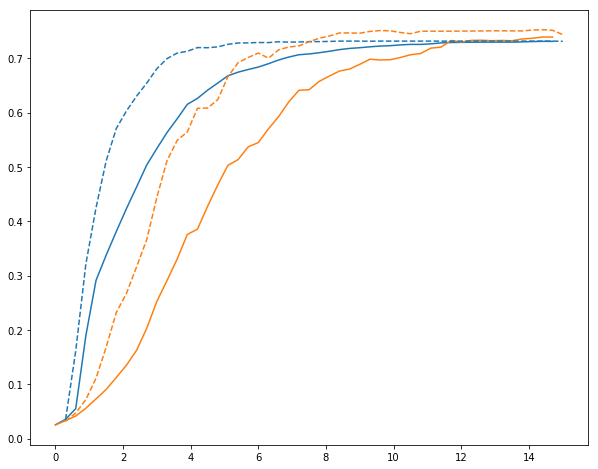

In [20]:
linestyles = ['-', '--']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(10, 8))
for i, rampe in enumerate(rampes):
    mean_df = mean_dfs[rampe]
    mu_values = mean_df.index
    C_values = mean_df.C
    Cws_values = mean_df.Cws
    
    
    ax.plot(mu_values, C_values, color=colors[0], linestyle=linestyles[i])
    ax.plot(mu_values, Cws_values, color=colors[1], linestyle=linestyles[i])
    #ax.set_xlim(8, 10)
    #ax.set_ylim(0.303, 0.307)
plt.show()

In [21]:
for rampe in rampes:
    print(rampe, dfs[rampe]['C'].max())

annealing 0.7311827956989247
cooling 0.7316503038803179


In [ ]:
dfs['cooling']['C'].max()

In [ ]:
mean_dfs['annealing'].iloc[0]

In [ ]:
std_dfs['annealing'].iloc[0]

In [ ]:
dfs['annealing'][:100].C.mean()

In [2]:
def build_df(net_dir, network, n_seeds, rand_mcs, samples):
    seeds = range(1, n_seeds+1)
    
    data = []
    for seed in seeds:

        seed_dir = 'seed{:05}'.format(seed)
        protocol = 'relaxation_randMCS{}_samples{}'.format(rand_mcs, samples)
        input_dir = os.path.join(net_dir, network, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)
        files = sorted(os.listdir(input_dir))  

        for f in files:
            swap = float(f[1:-4])
            full_path = os.path.join(input_dir, f)
            g = ig.Graph().Read_Edgelist(full_path, directed=False)
            C = g.transitivity_undirected(mode='zero')
            Cws = g.transitivity_avglocal_undirected(mode='zero')
            data.append([seed, swap, C, Cws])
    data = sorted(data, key=lambda x: x[0])    
    arr_data = np.array(data)

    columns = ['seed', 'swap', 'C', 'Cws']
    df = pd.DataFrame(data, columns=columns)
    return df

In [3]:
dfs = {}
mean_dfs = {}
std_dfs = {}

In [4]:
net_dir = '../../../networks/real'
n_seeds = 10
rand_mcs = 100
samples = 100

networks = ['ca-netscience', 
            #'ca-GrQc',
            'bio-yeast',
            'bio-diseasome',
            'bio-celegans',
            'powergrid',
            'euroroad_simple_gcc',
            #'CElegansNeural',
            'polblogs_simple_gcc',
            'EColiPIN_simple_gcc',
            'US-airports-500'
            ]

for network in networks:
    print(network)
    if network in dfs:
        continue
    df = build_df(net_dir, network, n_seeds, rand_mcs, samples)
    
    mean_df = df.groupby(by='swap').mean()
    del mean_df['seed']
    std_df = df.groupby(by='swap').std()
    del std_df['seed']

    dfs[network] = df
    mean_dfs[network] = mean_df
    std_dfs[network] = std_df

ca-netscience
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad_simple_gcc
polblogs_simple_gcc
EColiPIN_simple_gcc
US-airports-500


ca-netscience
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad
polblogs
EColiPIN
US-airports-500


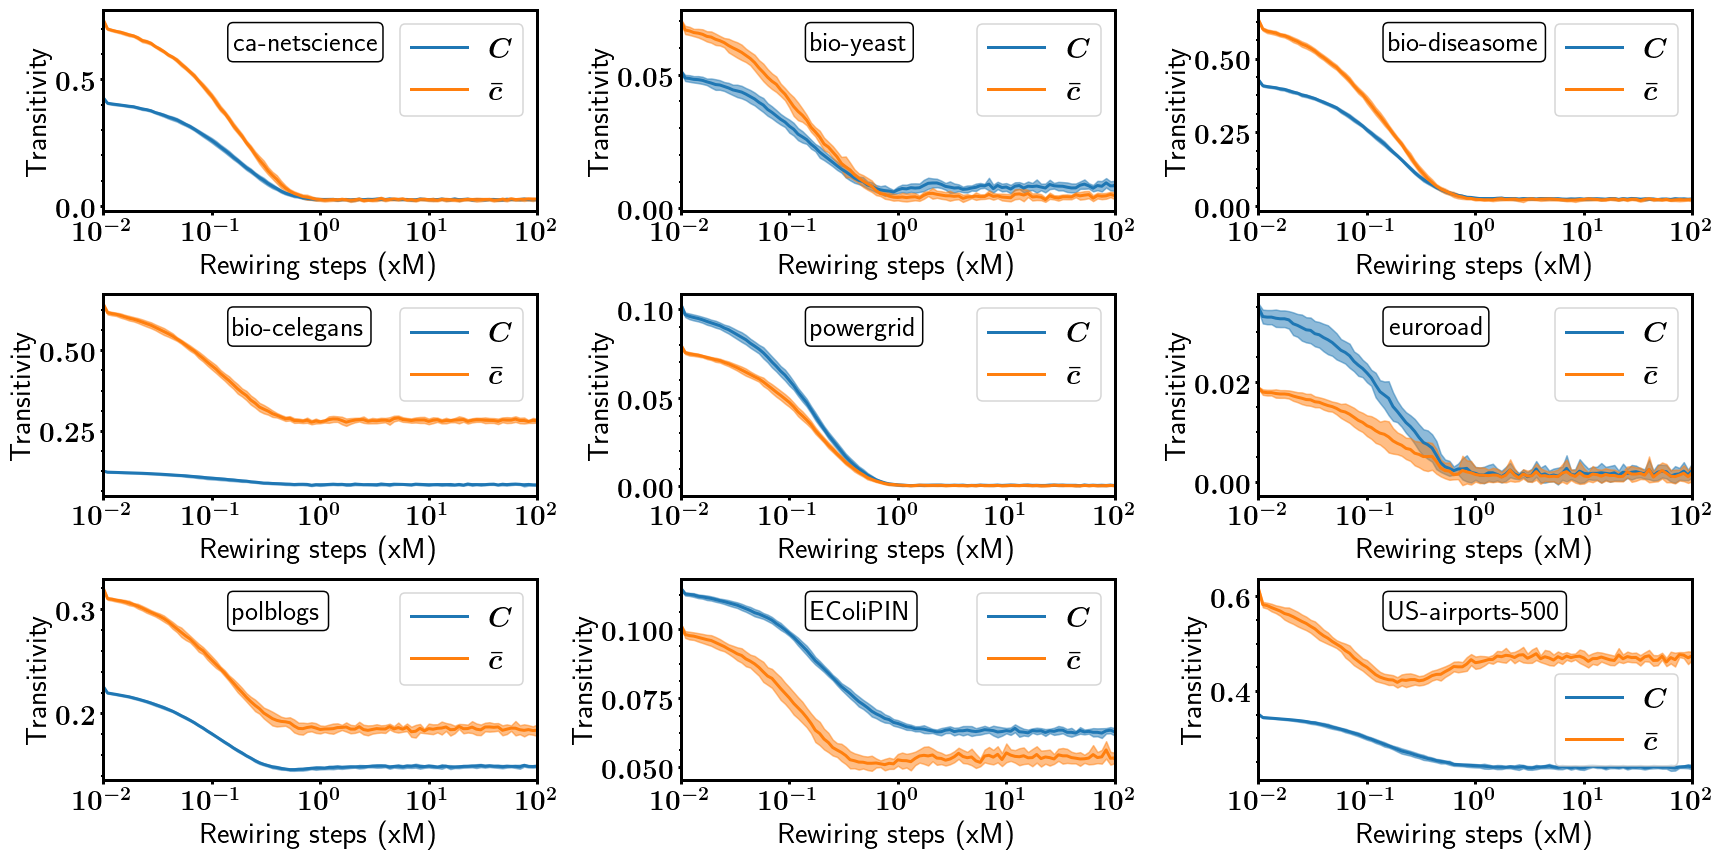

In [5]:
ncols, nrows = 3, 3
fig, axes = plt.subplots(figsize=(8*ncols, 4*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel('Rewiring steps (xM)')
    ax.set_ylabel('Transitivity')
    ax.set_xscale('log')
    ax.set_xlim(0.01, 100)
    
for ax, network in zip(axes.flatten(), networks):
    df = dfs[network]
    mean_df = mean_dfs[network]
    std_df = std_dfs[network]
    
    swap_values = mean_df.index
    C_values = mean_df.C
    Cws_values = mean_df.Cws
    ax.plot(swap_values, C_values, color=colors[0], label=r'$C$')
    ax.fill_between(swap_values, C_values-std_df.C, C_values+std_df.C, 
                    alpha=0.5, color=colors[0])
    ax.plot(swap_values, Cws_values, color=colors[1], label=r'$\bar{c}$')
    ax.fill_between(swap_values, Cws_values-std_df.Cws, Cws_values+std_df.Cws, 
                    alpha=0.5, color=colors[1])

    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network
    print(title)
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.3, 0.8, title, transform=ax.transAxes, bbox=bbox, fontsize=28)
    ax.legend(loc='best', fontsize=28)

plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'relaxation.pdf'))
plt.savefig(os.path.join(figs_dir, 'relaxation.png'))
plt.show()

In [10]:
from clustering_methods import get_C_rand_CM

C_rand_CM_values = {}
C_rand_rewire_values = {}
Cws_rand_CM_values = {}
Cws_rand_rewire_values = {}
for network in networks:
    print(network)
    full_path = os.path.join(net_dir, network, network + '.txt')
    g = ig.Graph().Read_Edgelist(full_path, directed=False)
    degSeq = g.degree()
    C_rand_CM_values[network], Cws_rand_CM_values[network] = get_C_rand_CM(degSeq, samples=10, package='ig')
    df = dfs[network]
    C_rand_rewire_values[network] = df[df['seed']==1].C[-100:]
    Cws_rand_rewire_values[network] = df[df['seed']==1].Cws[-100:]

ca-netscience
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad_simple_gcc
polblogs_simple_gcc
EColiPIN_simple_gcc
US-airports-500


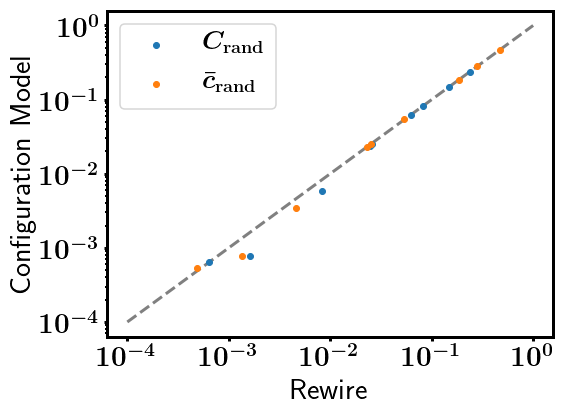

In [21]:
C_rewire_mean_values = []
Cws_rewire_mean_values = []
C_CM_mean_values = []
Cws_CM_mean_values = []
for network in networks:
    
    C_CM_mean = C_rand_CM_values[network].mean()
    C_CM_std = C_rand_CM_values[network].std()
    C_rewire_mean = C_rand_rewire_values[network].mean()
    C_rewire_std = C_rand_rewire_values[network].std()
    
    Cws_CM_mean = Cws_rand_CM_values[network].mean()
    Cws_CM_std = Cws_rand_CM_values[network].std()
    Cws_rewire_mean = Cws_rand_rewire_values[network].mean()
    Cws_rewire_std = Cws_rand_rewire_values[network].std()
    
    C_rewire_mean_values.append(C_rewire_mean)
    Cws_rewire_mean_values.append(Cws_rewire_mean)
    C_CM_mean_values.append(C_CM_mean)
    Cws_CM_mean_values.append(Cws_CM_mean)
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax.set_xscale('log')
ax.set_yscale('log')
X = np.linspace(0.0001, 1, 100)
ax.plot(X, X, linestyle='--', color='grey')
ax.plot(C_rewire_mean_values, C_CM_mean_values, 'o', 
               color=colors[0], label=r'$C_{\mathrm{rand}}$')
ax.plot(Cws_rewire_mean_values, Cws_CM_mean_values, 'o',  
               color=colors[1], label=r'$\bar{c}_{\mathrm{rand}}$')
ax.set_xlabel('Rewire')
ax.set_ylabel('Configuration Model')
ax.legend(loc='best')
plt.savefig(os.path.join(draft_figs_dir, 'CrandCM_vs_CrandRewire.pdf'))
plt.savefig(os.path.join(figs_dir, 'CrandCM_vs_CrandRewire.png'))
plt.show()

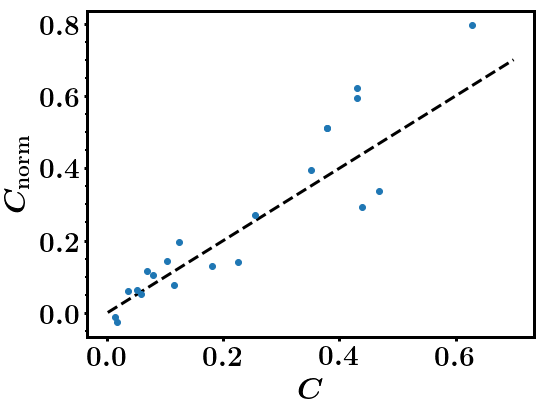

In [43]:
input_dir = '../../../data/clustering'
full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
with open(full_file_path, 'rb') as f:
    data = pickle.load(f)
    
C_values = []
Cws_values = []
for network, values in data.items():
    C_values.append(values['C'])
    Cws_values.append(values['Cws'])
C_values = np.array(C_values)
Cws_values = np.array(Cws_values)

ncols, nrows = 1, 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = [axes]
X = np.linspace(0.001, 0.7, 100)

ax = axes[0]
ax.plot(X, X, linestyle='--', color='k')
ax.plot(C_values[:,0], C_values[:,3], 'o')
ax.set_xlabel(r'$C$')
ax.set_ylabel(r'$C_{\mathrm{norm}}$')

if False:
    ax = axes[1]
    ax.plot(X, X, linestyle='--', color='k')
    ax.plot(Cws_values[:,0], Cws_values[:,3], 'o')
    ax.set_xlabel(r'$\bar{c}$')
    ax.set_ylabel(r'$\bar{c}_{\mathrm{norm}}$')
    
plt.savefig(os.path.join(draft_figs_dir, 'Cnorm_vs_C.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cnorm_vs_C.png'))
plt.show()